# overlap study for bioconda and biotools

## get list of biotools entries

In [2]:
import requests
import json
import os.path

biootools_list_file_name = 'biotools_list.json'
if os.path.isfile(biootools_list_file_name):
    with open(biootools_list_file_name) as biotools_list_json_file:    
        biotools_list = json.load(biotools_list_json_file)
        print('Loaded biotools web cache from https://bio.tools/api/tool/')
else:
    biotools_list = []
    next_biotools_page = '?page=1'
    while next_biotools_page is not None:
        print('getting page %s' % next_biotools_page)
        page = requests.get('https://bio.tools/api/tool/' + next_biotools_page).json()
        biotools_list += page['list']
        next_biotools_page = page['next']

    with open(biootools_list_file_name, 'w') as biotools_list_json_file:
        json.dump(biotools_list, biotools_list_json_file)

Loaded biotools web cache from https://bio.tools/api/tool/


_and get the list of biotools ids for these entries_

In [8]:
import pandas
biotools_ids = [element['id'] for element in biotools_list]
biotools_ids_processed = {}
for b in biotools_list:
    if 'BioConductor' in b['collectionID']:
        biotools_ids_processed['BIOCONDUCTOR-%s' % b['id'].upper()] = b['id']
    if 'EMBOSS' in b['collectionID']:
        biotools_ids_processed['BIOCONDUCTOR-%s' % b['id'].upper()] = b['id']
    else:
        biotools_ids_processed[b['id'].upper()] = b['id']
biotools_ids = pandas.DataFrame(list(biotools_ids_processed.items()), columns=['common', 'biotools'])
biotools_ids = biotools_ids.set_index('common')

## get list of bioconda entries

In [9]:
#repodata_url = 'https://conda.anaconda.org/bioconda/linux-64/repodata.json'
#repodata = requests.get(repodata_url).json()
bioconda_list_file_name = 'bioconda_list.json'
if os.path.isfile(bioconda_list_file_name):
    with open(bioconda_list_file_name) as bioconda_list_file:    
        bioconda_list = json.load(bioconda_list_file)
        print('Loaded bioconda file cache from https://conda.anaconda.org/bioconda/linux-64/repodata.json')
else:
    bioconda_list = requests.get('https://conda.anaconda.org/bioconda/linux-64/repodata.json').json()
    with open(bioconda_list_file_name, 'w') as bioconda_list_json_file:
        json.dump(bioconda_list, bioconda_list_json_file)

Loaded bioconda file cache from https://conda.anaconda.org/bioconda/linux-64/repodata.json


In [10]:
print(len(bioconda_list['packages'].items()))

10902


_and get the list of bioconda package names_

In [12]:
#bioconda_ids = [element['name'] for element in bioconda_list]
#print(bioconda_ids))
bioconda_ids = set([package['name'] for key, package in bioconda_list['packages'].items()])
bioconda_ids_processed = {}
for bioconda_id in bioconda_ids:
    if len(bioconda_id.split('-'))>1 and bioconda_id.split('-')[0]!='bioconductor':
        bioconda_ids_processed[bioconda_id.split('-')[1].upper()] = bioconda_id
    else:
        bioconda_ids_processed[bioconda_id.upper()] = bioconda_id
bioconda_ids = pandas.DataFrame(list(bioconda_ids_processed.items()), columns=['common', 'bioconda'])
bioconda_ids = bioconda_ids.set_index('common')
print(biotools_ids)
print(bioconda_ids)

                                                                      biotools
common                                                                        
LIGHTDOCK                                                            LightDock
SALMONELLA_CRISPR_TYPING                              Salmonella_CRISPR_typing
HADDOCK                                                                haddock
SETTER                                                                  setter
EDAL_-_ELECTRONIC_DATA_ARCHIVE_LIBRARY  eDAL_-_electronic_data_archive_library
ARRAYMAP                                                              arraymap
BGEE                                                                      bgee
CAMEO                                                                    cameo
BUSCO                                                                    busco
CLEANEX                                                                cleanex
HAMAP                                               

this is the intersection of biotools/biocondas entries, based on strict name equality

In [25]:
bioconda_ids.join(biotools_ids).to_csv('mapping.csv',na_rep='null')
bioconda_ids.join(biotools_ids).dropna().to_csv('mapping_matchonly.csv',na_rep='null')

intersection_biotools_bioconda = pandas.read_csv('mapping_matchonly.csv')
print(len(intersection_biotools_bioconda['common']))

681


In [17]:
not_in_bioconda =  set([b.upper() for b in biotools_ids['biotools']]) - set([b.upper() for b in bioconda_ids['bioconda']])
len(not_in_bioconda)

5997

In [16]:
not_in_biotools = set([b.upper() for b in bioconda_ids['bioconda']]) - set([b.upper() for b in biotools_ids['biotools']])
len(not_in_biotools)

2404

In [20]:
intersection = len(intersection_biotools_bioconda['common'])

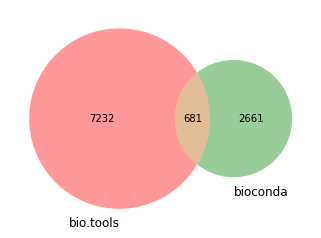

In [22]:
%matplotlib inline
from matplotlib_venn import venn2
venn2(subsets=(len(biotools_ids), len(bioconda_ids), intersection), set_labels = ('bio.tools', 'bioconda', 'overlap'))


questions:
* non-bioinformatics conda packages (yamllint?)
* packages that include a version number in biotools: ggplot2


In [23]:
[package for key, package in bioconda_list['packages'].items() if package['name']=='bioconductor-variantannotation']

[{'arch': 'x86_64',
  'binstar': {'channel': 'main',
   'owner_id': '55f35cc885a76554d7c66613',
   'package_id': '562657e9d6f51f0b163323ba'},
  'build': '0',
  'build_number': 0,
  'depends': ['bioconductor-annotationdbi >=1.27.9',
   'bioconductor-biobase',
   'bioconductor-biocgenerics >=0.15.3',
   'bioconductor-biostrings >=2.33.5',
   'bioconductor-bsgenome >=1.37.6',
   'bioconductor-genomeinfodb >=1.1.3',
   'bioconductor-genomicfeatures >=1.19.17',
   'bioconductor-genomicranges >=1.19.47',
   'bioconductor-iranges >=2.3.25',
   'bioconductor-rsamtools >=1.19.52',
   'bioconductor-rtracklayer >=1.25.16',
   'bioconductor-s4vectors >=0.7.11',
   'bioconductor-summarizedexperiment >=0.3.1',
   'bioconductor-xvector >=0.5.6',
   'bioconductor-zlibbioc',
   'r >=2.8.0',
   'r-dbi'],
  'license': 'Artistic-2.0',
  'machine': 'x86_64',
  'md5': 'f9182e4d677a705b0cc11125f572e9ad',
  'name': 'bioconductor-variantannotation',
  'operatingsystem': 'linux',
  'platform': 'linux',
  'requi

In [24]:
len([element for element in biotools_list if 'EMBOSS' in element['collectionID']])

253